In [17]:
import gdal, osr
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import fiona

In [2]:
from matplotlib.colors import ListedColormap

In [18]:
class RasterProp:
    def __init__(self,
                 rasterFile,
                 sliceClass=None, slicing = False):
        self.raster = gdal.Open(rasterFile)
        self.geotransform = self.raster.GetGeoTransform()
        self.projRef      = self.raster.GetProjectionRef()
        self.originX = self.geotransform[0]
        self.originY = self.geotransform[3] 
        self.pixelWidth = self.geotransform[1] 
        self.pixelHeight = self.geotransform[5]
        
        if slicing:
            print('recomputing origin')
            x_ori_rel , y_ori_rel, xlen, ylen = sliceClass.relevantArea()
            self.originX, self.originY = pixel2coord(self.geotransform, 
                                                     x_ori_rel, 
                                                     y_ori_rel)
            
def array2raster(array, rasProp,newRasterfn):
    print('converting array to raster...')
    cols = array.shape[1]
    rows = array.shape[0]
    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create( newRasterfn, 
                              cols, rows,
                              bands=1, 
                              eType= gdal.GDT_Float32)
    outRaster.SetGeoTransform((rasProp.originX, 
                               rasProp.pixelWidth, 
                               0, rasProp.originY, 
                               0, rasProp.pixelHeight))
    
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(array)
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromWkt(rasProp.projRef)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()

In [19]:
def raster2array(rasterfn):
    #print('converting raster to array...')
    raster = gdal.Open(rasterfn)
    band = raster.GetRasterBand(1)
    array = band.ReadAsArray()
    return array

In [6]:
sloCost = raster2array(os.path.abspath('01_Data500/slope.tif'))
envCost = raster2array(os.path.abspath('01_Data500/fac_env.tif'))
infCost = raster2array(os.path.abspath('01_Data500/fac_inf.tif'))
pubCost = raster2array(os.path.abspath('01_Data500/fac_pub.tif'))
allCost = (ecoCost+envCost+infCost+pubCost)/4

# Line Length

In [5]:
epi111P = os.path.abspath('02_DC_Projects_DE/02_dc5_paths/eip_111'+'.npy')
eip111 = np.load(epi111P)

In [10]:
len(eip111[0])

836

In [20]:
def lineLength_numberOfCells(lineIdx):
    return len(lineIdx[0])     

In [21]:
def lineLength(lineArray):
    indicies = np.nonzero(lineArray)
    indicies_paired = np.stack((indicies[0],indicies[1]), axis=-1)
    disTot = 0
    for point in range(1,len(indicies_paired)-1,1):
        x1 = indicies_paired[point-1][0]
        y1 = indicies_paired[point-1][1]
        x2 = indicies_paired[point][0]
        y2 = indicies_paired[point][1]
        dist = np.sqrt((x2-x1)**2+(y2-y1)**2)*0.5
        disTot = disTot+dist
    return disTot

In [38]:
def lineLength_idx(lineIdx):
    indicies_paired = np.transpose(lineIdx)
    disTot = 0
    for point in range(1,len(indicies_paired)-1,1):
        x1 = indicies_paired[point-1][0]
        y1 = indicies_paired[point-1][1]
        x2 = indicies_paired[point][0]
        y2 = indicies_paired[point][1]
        dist = np.sqrt((x2-x1)**2+(y2-y1)**2)*0.5
        disTot = disTot+dist
    return int(disTot)

In [18]:
fileName = str(3)+str(2)+str(5)
comName = os.path.abspath('03_DC_Project_North/02_paths_2/eip_'+fileName+'.npy')

In [29]:
eip_325 = np.load(comName)

In [38]:
pd.DataFrame(eip_325).to_excel(os.path.abspath('03_DC_Project_North/02_paths/eip_'+'325.xlsx'))


In [27]:
eip_325[0]

array([1211, 1212, 1213, ..., 2103, 2104, 2105])

In [39]:
lineLength_idx(np.load(os.path.abspath('02_DC_Projects_DE/02_dc5_paths/eip_'+'222'+'.npy')))

2.0615528128088303
4493 4034 4494 4030
1.5811388300841898
4494 4030 4495 4027
1.5811388300841898
4495 4029 4496 4026


470

# Population Affected

In [23]:
popu = raster2array(os.path.abspath('01_Data500/population.tif'))
def peopleAff(line):
    return popu[line[0],line[1]].sum()

In [24]:
def peopleAffected(line, basedOn):
    path = line_path(path_based_on=basedOn, dc = line)
    return np.multiply(popu,path).sum()

## Corine

In [25]:
corOrig = os.path.abspath('01_Data500/corine_500_original_classification.tif')
landOrig = raster2array(corOrig)

In [26]:
corClas = pd.read_csv('Corine_Classification.csv', delimiter=';')[['CLC','Class_name']]

In [27]:
def corineClassPath(factor, line):
    dc1EcoPath = line_path(path_based_on=factor,dc=line)
    dc1EcoCor = np.multiply(dc1EcoPath,landOrig)
    value, counts = np.unique(dc1EcoCor, return_counts=True)
    corPath = pd.DataFrame([value,counts]).T
    corPath.columns =['CLC','count']
    corClasPath = corPath.set_index('CLC').join(corClas.set_index('CLC'))
    corClasDef = corClasPath.dropna().groupby('Class_name').sum()
    corClasDef.columns = [factor]
    return corClasDef

In [28]:
def getCorineClass(line):
    dc1Eco = corineClassPath(factor='eco',line=line)
    dc1Env = corineClassPath(factor='env',line=line)
    dc1Inf = corineClassPath(factor='inf',line=line)
    dc1Pub = corineClassPath(factor='pub',line=line)
    dc1All = corineClassPath(factor='all',line=line)
    dc1CorFac = dc1Eco.join(dc1Env, 
                            how='outer').join(dc1Inf,
                                             how='outer').join(dc1Pub, how='outer').join(dc1All, how='outer')
    return dc1CorFac

## Corine Classification

In [29]:
corOrig = raster2array(os.path.abspath('01_Data500/corine_500_original_classification.tif'))
def getCorineCLC(line):
    clcCode, clcCounts = np.unique(corOrig[line[0],line[1]], return_counts=True)
    return dict(zip(clcCode, clcCounts))
 
corClass = pd.read_excel('Corine_Classification.xlsx').set_index('CLC')

## 'Similarness' of the path

## Buffer Intersection

**Approch**

Create a buffer of 1.5KM (randomly choosen number) and calculating the fraction of intersection of the two buffer zones.

**Method**

*Step1:* Select cell indexes with path (non-zero values with path array). A list of tuples is created containing the path

*Step2:* Add the buffer tuples to the list of tuples. Here it is possible to change the buffer zone. This will add multiple tuples with same values. Hence, important to select only unique tuples. This is done with the set operator. 

*Step3:* Count the number of tuples common in the paths been compared

*Step4:* Normalize with the number of cells in the buffer zone of the normalized path. 



In [30]:
def getBuffPathLocations(line, bufferLength=3):
    y,x = line[0], line[1]
    orgList = list(zip(x,y))
    bufList = []
    for item in orgList:
        for shift in range(0,bufferLength,1):
            bufList.append((item[0]-shift,item[1]))
            bufList.append((item[0]+shift,item[1]))
            bufList.append((item[0]      ,item[1]-shift))
            bufList.append((item[0]      ,item[1]+shift))

            bufList.append((item[0]-shift,item[1]-shift))
            bufList.append((item[0]+shift,item[1]+shift))

            bufList.append((item[0]-shift,item[1]+shift))
            bufList.append((item[0]+shift,item[1]-shift)) 
    return set(bufList)


def getIntersection(bufRef, bufList2):
    intLen = len(bufRef.intersection(bufList2))
    return intLen/len(bufRef)

In [31]:
line_eip111 = np.load(os.path.abspath('03_DC_Project_North/02_paths_2/eip_111.npy'))
line_eip111

array([[1211, 1212, 1213, ..., 2103, 2104, 2105],
       [4834, 4834, 4835, ..., 5445, 5446, 5447]], dtype=int64)

In [31]:
dc5Actual = raster2array(os.path.abspath('02_DC_Projects_DE/DC_5_real.tif'))
dc5ActualIdx = np.nonzero(dc5Actual)

## ProtectedZone length

In [32]:
prot = raster2array(os.path.abspath('01_Data500/protected.tif'))
def getProtectedCells(line):
    return prot[line[0],line[1]].sum()/10
#getProtectedCells(l1113)

## Slope Classification

In [33]:
sloCost = raster2array(os.path.abspath('01_Data500/slope.tif'))
def returnSlopeClass(line):
    slopVals = sloCost[line[0],line[1]]
    slopValsCount = np.unique(np.digitize(slopVals, [1.146,4.574]), return_counts=True)[1]
    return list(slopValsCount)

# AllPaths

In [36]:
factors = []
for env in range(0,11,1):
    for inf in range(0,11,1):
        for pub in range(0,11,1):
            factors.append([env,inf,pub])

In [42]:
peopleAffected = []
protZonePassed = []
lineLength     = []
#buffInter_dc5Actual = []
buffInter_eip111 =  []
slopeClassData = []
corineCLCCount = []
lineNumberOfCells = []

#refBuffAct = getBuffPathLocations(dc5ActualIdx)
refBuff111 = getBuffPathLocations(line_eip111)
for env in range(0,11,1):
    for inf in range(0,11,1):
        for pub in range(0,11,1):
            if (env == inf==pub==0):
                continue;
                        
            fileName = str(env)+str(inf)+str(pub)
            comName = os.path.abspath('03_DC_Project_North/02_paths_2/eip_'+fileName+'.npy')
            path = np.load(comName)
            print(env,inf,pub)

        # line number of cells
            def lineNumCell():
                linNumCell = lineLength_numberOfCells(path)
                lineNumberOfCells.append([env/(env+inf+pub),
                                            inf/(env+inf+pub),
                                            pub/(env+inf+pub),linNumCell])


        # line length
            def lineLength():
                print('linelength')
                lineLen = lineLength_idx(path)
                lineLength.append([env/(env+inf+pub),
                                            inf/(env+inf+pub),
                                            pub/(env+inf+pub),lineLen])


        # corine CLC code

            def corCLC():
                print('corCLC')
                corCLC = getCorineCLC(path)
                corineCLCCount.append([env/(env+inf+pub),
                                       inf/(env+inf+pub),
                                       pub/(env+inf+pub),corCLC])


        # slope class
            def slopClass():

                print('slope class')
                slopClass = [env/(env+inf+pub), 
                                         inf/(env+inf+pub), 
                                         pub/(env+inf+pub), 
                                         returnSlopeClass(path)[0],
                                         returnSlopeClass(path)[1],
                                         returnSlopeClass(path)[2]]
                slopeClassData.append(slopClass)


        # people affected
            def peopleAffVal():

                print('People Aff')
                linPplAff = peopleAff(path)
                peopleAffected.append([env/(env+inf+pub),
                                               inf/(env+inf+pub),
                                               pub/(env+inf+pub),linPplAff])


        # buffer wrt to actual
        #            print('actBuff')
        #            buffInt = getIntersection(refBuffAct,
        #                                      getBuffPathLocations(path))
        #            buffInter_dc5Actual.append([env/(env+inf+pub),
         #                                  inf/(env+inf+pub),
         #                                  pub/(env+inf+pub),buffInt])

        # buffer wrt to eip_111
            print('111Buff')
            buffInt = getIntersection(refBuff111,
                                        getBuffPathLocations(path))
            buffInter_eip111.append([env/(env+inf+pub),
                                        inf/(env+inf+pub),
                                        pub/(env+inf+pub),buffInt])


        # protected zone cells
            def protCells():

                print('protCells')
                protZnLin = getProtectedCells(path)
                protZonePassed.append([env/(env+inf+pub),
                                            inf/(env+inf+pub),
                                            pub/(env+inf+pub),protZnLin])
            lineNumCell()
            #lineLength()
            corCLC()
            slopClass()
            peopleAffVal()
            protCells()

0 0 1
111Buff
corCLC
slope class
People Aff
protCells
0 0 2
111Buff
corCLC
slope class
People Aff
protCells
0 0 3
111Buff
corCLC
slope class
People Aff
protCells
0 0 4
111Buff
corCLC
slope class
People Aff
protCells
0 0 5
111Buff
corCLC
slope class
People Aff
protCells
0 0 6
111Buff
corCLC
slope class
People Aff
protCells
0 0 7
111Buff
corCLC
slope class
People Aff
protCells
0 0 8
111Buff
corCLC
slope class
People Aff
protCells
0 0 9
111Buff
corCLC
slope class
People Aff
protCells
0 0 10
111Buff
corCLC
slope class
People Aff
protCells
0 1 0
111Buff
corCLC
slope class
People Aff
protCells
0 1 1
111Buff
corCLC
slope class
People Aff
protCells
0 1 2
111Buff
corCLC
slope class
People Aff
protCells
0 1 3
111Buff
corCLC
slope class
People Aff
protCells
0 1 4
111Buff
corCLC
slope class
People Aff
protCells
0 1 5
111Buff
corCLC
slope class
People Aff
protCells
0 1 6
111Buff
corCLC
slope class
People Aff
protCells
0 1 7
111Buff
corCLC
slope class
People Aff
protCells
0 1 8
111Buff
corCLC
slope 

### Restructuring and saving indicators

In [29]:
# similarness relative to actual (only valid for dc5)
buff_actual = pd.DataFrame(buffInter_dc5Actual, 
                 columns=['env','inf','pub','buff_actual'])
buff_actual.to_excel(os.path.abspath('03_DC_Project_North/03_analysis_2/eip_buff_actual.xlsx'))

NameError: name 'buffInter_dc5Actual' is not defined

In [45]:
# similarness relative to 111 path
buffeip111_paths = pd.DataFrame(buffInter_eip111, 
                columns=['env','inf','pub','buf_111'])
buffeip111_paths.drop_duplicates().to_excel(os.path.abspath('03_DC_Project_North/03_analysis_2/eip_buff.xlsx'))

In [44]:
# number of cells
lineNumberOfCells_paths = pd.DataFrame(lineNumberOfCells,
             columns=['env','inf','pub','line_numberOfCells'])
lineNumberOfCells_paths.drop_duplicates().to_excel(os.path.abspath('03_DC_Project_North/03_analysis_2/eip_lineNumberOfCells.xlsx'))

In [53]:
# people affected
pplAffected_paths = pd.DataFrame(peopleAffected, 
                         columns=['env','inf','pub','peopleAff'])
pplAffected_paths.drop_duplicates().to_excel(os.path.abspath('03_DC_Project_North/03_analysis_2/eip_peopleAffected.xlsx'))



#dc5Lengths = pd.DataFrame(lineLength, 
#                         columns=['env','inf','pub','dc5Length'])
#dc5Lengths.drop_duplicates().to_excel(os.path.abspath('03_DC_Project_North/03_analysis/eip_length.xlsx'))

In [47]:
# protected zone cells
dc5Protzon_paths = pd.DataFrame(protZonePassed, 
                         columns=['env','inf','pub','protZoneCells'])
dc5Protzon_paths.drop_duplicates().to_excel(os.path.abspath('03_DC_Project_North/03_analysis_2/eip_protZoneCells.xlsx'))


In [48]:
# slope classification
slopClass_paths = pd.DataFrame(slopeClassData, columns={'env','inf','pub','low','med','high'})
slopClass_paths.drop_duplicates().to_excel(os.path.abspath('03_DC_Project_North/03_analysis_2/eip_slopeClass.xlsx'))

In [49]:
# 
CLCCount_paths = pd.DataFrame(corineCLCCount,
                          columns={'env','inf','pub','clc_count'} )
CLCCount_paths.to_excel(os.path.abspath('03_DC_Project_North/03_analysis_2/eip_clcCount.xlsx'))

## corine mapping to defined classes

In [50]:
corinClassification = []
for row in dc5CLCCount.iterrows():
    lineCounts = pd.DataFrame.from_dict(dict(row[1].clc_count), orient='index', columns=['clc_count'])
    corineClassNameCount = corClass.join(lineCounts).fillna(0)[['Class_name','clc_count']].groupby('Class_name').sum().T
    clasList = list(corineClassNameCount.values[0])
    clasList.extend([row[1].env, row[1].inf, row[1].pub])
   
    corinClassification.append(clasList)
   
columns = ['Agriculture', 'Forest', 'HVN', 'Man-Made', 'Wasteland','env', 'inf', 'pub']
 
corinClassDF = pd.DataFrame(corinClassification, columns=columns)
corinClassDF.drop_duplicates().to_excel(os.path.abspath('03_DC_Project_North/03_analysis_2/eip_corinClassification.xlsx'))

NameError: name 'dc5CLCCount' is not defined

## Raster of number of paths through cells

In [121]:
allPathIdxs = []
for env in range(0,11,1):
    for inf in range(0,11,1):
        for pub in range(0,11,1):
            if (env==inf==pub==0):
                break;
            fileName = str(env)+str(inf)+str(pub)
            comName = os.path.abspath('02_DC_Projects_DE/02_dc5_paths/eip_'+fileName+'.npy')
            path = np.load(comName)
            allPathIdxs.append(path)

In [122]:
allPathPairs =[]
for path in allPathIdxs:
    allPathPairs.append(np.transpose(path))
    

In [124]:
coordList = list(map(tuple,np.vstack(allPathPairs)))

In [125]:
from collections import Counter
valCounts = dict(Counter(elem for elem in coordList))

In [136]:
np.save(os.path.abspath('02_DC_Projects_DE/03_dc5_analysis/eip_pathsMap.npy'),areaMap)

In [85]:
areaMap

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [126]:
np.shape(protZone)

(8685, 8837)

In [127]:
areaMap = np.zeros(shape=np.shape(protZone))
np.put(areaMap,list(dict(valCounts).keys()),list(dict(valCounts).values()))
areaMap

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

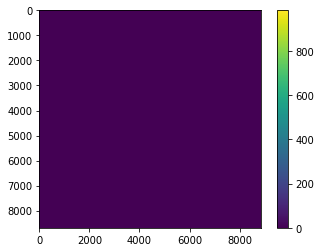

In [131]:
plt.imshow(areaMap)
plt.colorbar()
plt.savefig('pathCountour.pdf')

In [120]:
areaMap.tofile(os.path.abspath('02_DC_Projects_DE/03_dc5_analysis/eip_pathContour.csv'))

In [119]:
array2raster(areaMap, 
             RasterProp(os.path.abspath('01_Data500/corine.tif')),
            os.path.abspath('02_DC_Projects_DE/03_dc5_analysis/eip_pathContour.tif'))

converting array to raster...


In [115]:
array2raster(areaMap, 
             RasterProp(os.path.abspath('01_Data500/protected.tif')),
             )

converting array to raster...


In [3]:
areaMap = np.load(os.path.abspath('02_DC_Projects_DE/03_dc5_analysis/eip_pathsMap.npy'))

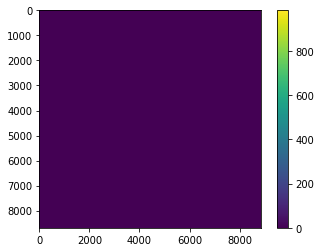

In [8]:
plt.imshow(areaMap)
plt.colorbar()

In [14]:
pd.DataFrame(areaMap).to_csv(os.path.abspath('02_DC_Projects_DE/03_dc5_analysis/eip_pathContour.csv'))

In [11]:
array2raster(areaMap, 
             RasterProp(os.path.abspath('01_Data500/corine.tif')),
             os.path.abspath('02_DC_Projects_DE/03_dc5_analysis/eip_pathContour.tif'))

converting array to raster...


## Indicators for actual

In [54]:
dc5ActCLC = getCorineCLC(dc5ActualIdx)

In [56]:
lineCounts = pd.DataFrame.from_dict(dc5ActCLC, orient='index', columns=['clc_count'])
corineClassNameCount = corClass.join(lineCounts).fillna(0)[['Class_name','clc_count']].groupby('Class_name').sum().T
clasList = list(corineClassNameCount.values[0])
print(clasList)
#clasList.extend([row[1].env, row[1].inf, row[1].pub])

[834.0, 135.0, 0.0, 5.0, 0.0]


In [49]:
dc5Act = pd.DataFrame([['lineLength', lineLength_idx(dc5ActualIdx)],
 ['lineNumCells', lineLength_numberOfCells(dc5ActualIdx)],
 ['peopAff', peopleAff(dc5ActualIdx)],
 ['protZoneCells', getProtectedCells(dc5ActualIdx)]], columns=['prop','value'])

In [51]:
dc5Act.to_excel(os.path.abspath('02_DC_Projects_DE/03_dc5_analysis/dc5Act_properties.xlsx'))

In [ ]:
dc5Act 

# ternary Plot

In [3]:
import ternary

In [4]:
peopleAff = pd.read_excel(os.path.abspath('02_DC_Projects_DE/03_dc5_analysis/eip_peopleAffected.xlsx'))

In [5]:
peopleAff.describe()

,env,inf,pub,peopleAff
count,1320.000000,1320.000000,1320.000000,1320.000000
mean,0.335859,0.335859,0.328283,18007.912879
std,0.204668,0.204668,0.198350,9221.636086
min,0.000000,0.000000,0.000000,1412.000000
25%,0.187500,0.187500,0.181818,10620.000000
50%,0.333333,0.333333,0.333333,19459.000000
75%,0.461538,0.461538,0.454545,23967.250000
max,1.000000,1.000000,0.909091,36124.000000


In [6]:
pplAffDict = peopleAff.set_index(['env','inf','pub']).T.to_dict('list')

/Users/samarth/miniconda3/envs/gis/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  """Entry point for launching an IPython kernel.


In [8]:
pplAffDictValue = {}
for key, value in pplAffDict.items():
    pplAffDictValue[(key[0], key[1])] = value[0]
    

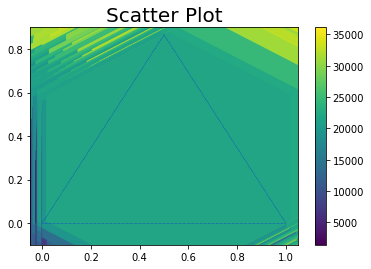

In [10]:
import ternary

    ### Scatter Plot
scale = 0
figure, tax = ternary.figure(scale=scale)
tax.set_title("Scatter Plot", fontsize=20)
#tax.boundary(linewidth=2.0)
tax.gridlines(multiple=5, color="blue")
    # Plot a few different styles with a legend
#points = random_points(30, scale=scale)
tax.heatmap(pplAffDictValue, style='h')
#points = random_points(30, scale=scale)
#tax.scatter(points, marker='D', color='green', label="Green Diamonds")
#tax.legend()
#tax.ticks(axis='lbr', linewidth=1, multiple=5)
tax.show()

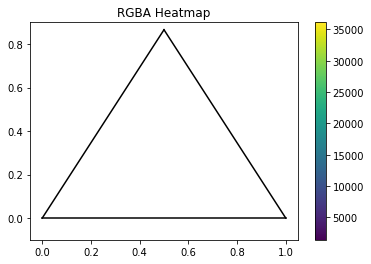

In [14]:
figure, tax = ternary.figure()
tax.heatmap(pplAffDictValue, style="triangular")
tax.boundary()
tax.set_title("RGBA Heatmap")
plt.show()